# Toy Example (20 Points)
This first part contains some test-loss surfaces and a complete training loop, to give a play ground for testing out different optimizers. You will need this environment to answer the questions from the ISIS-quiz. The code is based on torch. 
You can find the documentation of the optimizers here: https://pytorch.org/docs/stable/optim.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
from torch import nn
from torch.utils.data import DataLoader


from torchvision.datasets import MNIST
from torchvision import transforms as T


import utils

from utils import plot_loss_surface_toy, train_toy, func0, func1, func2, func3

There are four different loss functions ```func0, func1, func2, func3```. 

```
train_toy(
    loss_func: function,
    optim: type,
    optim_kwargs: dict,
    bs=0: int
)
```
is an implementation for initializing and training a toy model on these toy problems.
The arguments are 
- the loss function ```loss_func```, 
- the optimizer type ```optim```, 
- the key-word arguments ```optim_kwargs``` for initializing the optimizer 
- and the batch-size ```bs```. If ```bs``` is set to 0, then you have full-batch gradient descent.

Furthermore ```plot_loss_surface_toy``` plots the loss surface of a given loss function.

A minimal example is given below

torch.optim.sgd.SGD: {'lr': 0.1} full-batch||loss = 0.01
torch.optim.sgd.SGD: {'lr': 0.1} batch-size: 128||loss = 0.01


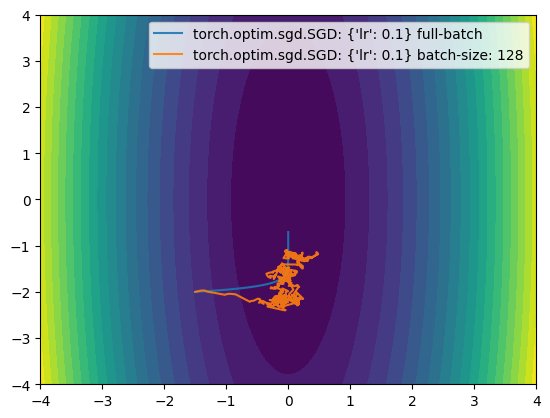

In [2]:

plot_loss_surface_toy(func1)
# Gradient descent (full-batch)
train_toy(func1, optim=torch.optim.SGD, optim_kwargs={'lr': 0.1})

# Stochastic Gradient Descent with batch-size 128
train_toy(func1, optim=torch.optim.SGD, bs=128, optim_kwargs={'lr': 0.1})

_ = plt.legend()

# Introduction

Momentum has been introduced in the lecture as a mechanism to speed up training.
We would like to show this empirically in this exercise by an example on the MNIST dataset.
We use a simple network architecture to classify handwritten digits into 10 different classes (0-9).

Your task is to implement some parts of the training loop and study the effect of momentum with respect to the training speed.
We compare training the model with Stochastic Gradient Descent (SGD) without momentum and with a momentum of `0.9`.
To highlight that the effect is not the result of a specific hyperparameter choice, we train with different batch sizes and learning rates.
For each of these configurations, we train two models: one with SGD and the other with SGD and momentum.


In [3]:
# loading data
data_root = './data'
train_dataset = MNIST(data_root, train=True, download=True, transform=T.ToTensor())
test_dataset = MNIST(data_root, train=False, download=True, transform=T.ToTensor())

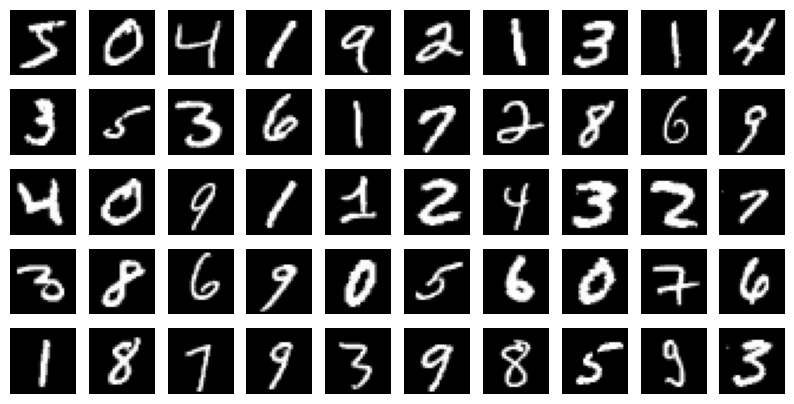

In [4]:
# visualizing samples
utils.show_samples(train_dataset)

# Training Function Implementation

**Task:** Implement the training function. You may use the predefined `train_one_epoch` function provided in `utils.py`.
It has the following signature
```
train_one_epoch(
        model: torch.nn.Sequential,
        train_loader: DataLoader,
        criterion: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
    )
```
The training function receives a random initialized model and various hyperparameters. Your task is to
implement the training loop given the function `train_one_epoch`. We want to optimize the model with a cross entropy loss.
Further, we want to collect the final train and test accuracy and also how the training metrics progress over the training.


Therefore, also return the train loss and accuracy after each epoch of the training for further analysis.

*Hint:* to compute the final training and test accuracy after training, you can use the `accuracy` function from `utils.py`



In [5]:
from utils import accuracy
def train(model, train_dataset, test_dataset, epochs=10, batch_size=32, lr=0.01, momentum=0.0):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # Lists to store training metrics
    arr_epoch_loss = []
    arr_epoch_train_accuracy = []
    
    for epoch in range(epochs):
        # Training for one epoch
        epoch_loss, epoch_train_accuracy = utils.train_one_epoch(model, train_loader, torch.nn.CrossEntropyLoss(), optimizer)
        arr_epoch_loss.append(epoch_loss)
        
        arr_epoch_train_accuracy.append(epoch_train_accuracy)
        
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {epoch_loss:.4f} - Train Acc: {arr_epoch_train_accuracy[-1]:.4f}")


    train_acc = utils.accuracy(model, train_loader)
    test_acc = utils.accuracy(model, test_loader)   
    return train_acc, test_acc, arr_epoch_loss, arr_epoch_train_accuracy

In [10]:
# sanity check for model training
torch.manual_seed(1)
model = utils.Lenet5()
print(train(model=model, train_dataset=train_dataset, test_dataset=test_dataset, epochs=1));

Epoch [1/1] - Train Loss: 2.3016 - Train Acc: 0.1093
(0.11236666887998581, 0.11349999904632568, [2.3016252517700195], [0.10926666855812073])


In [11]:
torch.manual_seed(1)
model2 = utils.Lenet5()
print(train(model=model2, train_dataset=train_dataset, test_dataset=test_dataset, epochs=1, momentum=0.9));

Epoch [1/1] - Train Loss: 0.9063 - Train Acc: 0.6739
(0.940416693687439, 0.944100022315979, [0.9063395857810974], [0.6738666892051697])


# Hyperparameter-search of momentum, learning rate and batch-size

**Task:** We want to compare the effect of momentum on the optimization process for different learning rates.
Use the previously created training function to implement the function `sweep` which should try all possible combinations of given hyperparameters. 
For each of the two trained models, plot the loss value after each epoch to study how the loss progresses during training.
Train the network on MNIST for 5 epochs and span a grid with the hyperparameters: learning rate ```lr``` $\in \{0.5, 0.1\}$, batchsize ```batch_size``` $\in \{16, 32\}$ and momentum ```momentum``` $\in \{0.0, 0.9\}$.
Evaluate the training and test loss.

What can you observe from these plots? What influence does momentum have on the training? Answer the ISIS-quiz.

In [8]:
import matplotlib.pyplot as plt
def sweep(arr_lr, arr_batchsize, arr_mom, train_dataset, test_dataset, epochs=5):   
    fig, axarr = plt.subplots(len(arr_lr), len(arr_batchsize))
    xrange = list(range(1, epochs+1))
    for ix, lr in enumerate(arr_lr):
        for iy, bs in enumerate(arr_batchsize):
            for _, mom in enumerate(arr_mom):
                torch.manual_seed(1)
                model = utils.Lenet5()
                _, test_acc, arr_epoch_loss, _ = train(
                    model=model,
                    train_dataset=train_dataset,
                    test_dataset=test_dataset,
                    batch_size=bs,
                    lr=lr,
                    epochs=epochs,
                    momentum=mom
                )
                axarr[ix, iy].plot(xrange, arr_epoch_loss, label=f"mom={mom:.1f} - Test-acc {test_acc:.4f}")
            axarr[ix, iy].set_title(f"lr {lr:.1e} - bs {bs}")
            axarr[ix, iy].set_ylabel("loss")
            axarr[ix, iy].legend()
            axarr[ix, iy].set_xticks(xrange)
            axarr[ix, iy].set_xlabel("Epoch")
    


Epoch [1/5] - Train Loss: 2.2971 - Train Acc: 0.1205
Epoch [2/5] - Train Loss: 0.9048 - Train Acc: 0.7042
Epoch [3/5] - Train Loss: 0.2795 - Train Acc: 0.9125
Epoch [4/5] - Train Loss: 0.1890 - Train Acc: 0.9411
Epoch [5/5] - Train Loss: 0.1503 - Train Acc: 0.9546
Epoch [1/5] - Train Loss: 0.5699 - Train Acc: 0.7988
Epoch [2/5] - Train Loss: 0.1045 - Train Acc: 0.9682
Epoch [3/5] - Train Loss: 0.0756 - Train Acc: 0.9766
Epoch [4/5] - Train Loss: 0.0606 - Train Acc: 0.9817
Epoch [5/5] - Train Loss: 0.0532 - Train Acc: 0.9834
Epoch [1/5] - Train Loss: 2.3016 - Train Acc: 0.1093
Epoch [2/5] - Train Loss: 2.2911 - Train Acc: 0.1373
Epoch [3/5] - Train Loss: 1.2373 - Train Acc: 0.5881
Epoch [4/5] - Train Loss: 0.4590 - Train Acc: 0.8563
Epoch [5/5] - Train Loss: 0.2916 - Train Acc: 0.9097
Epoch [1/5] - Train Loss: 0.9063 - Train Acc: 0.6739
Epoch [2/5] - Train Loss: 0.1412 - Train Acc: 0.9568
Epoch [3/5] - Train Loss: 0.0998 - Train Acc: 0.9693
Epoch [4/5] - Train Loss: 0.0791 - Train Acc: 

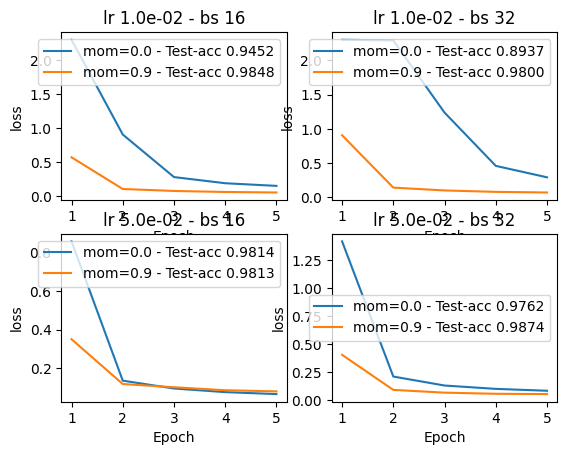

In [12]:
sweep(arr_lr=[0.01, 0.05], arr_batchsize=[16, 32], arr_mom=[0.0, 0.9], train_dataset=train_dataset, test_dataset=test_dataset)